In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Comparing Nearest Neighbors with and without Neighborhood Components Analysis
An example comparing nearest neighbors classification with and without Neighborhood Components Analysis.

It will plot the class decision boundaries given by a Nearest Neighbors classifier when using the Euclidean distance on the original features, versus using the Euclidean distance after the transformation learned by Neighborhood Components Analysis. The latter aims to find a linear transformation that maximises the (stochastic) nearest neighbor classification accuracy on the training set.

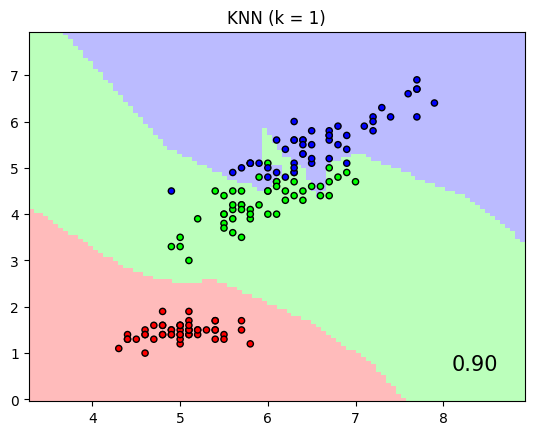

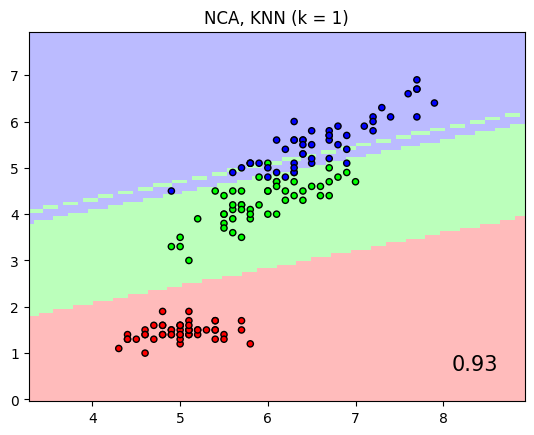

In [2]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 1

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target

# we only take two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = X[:, [0, 2]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.7, random_state=42
)

h = 0.05  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

names = ["KNN", "NCA, KNN"]

classifiers = [
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=n_neighbors)),
        ]
    ),
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("nca", NeighborhoodComponentsAnalysis()),
            ("knn", KNeighborsClassifier(n_neighbors=n_neighbors)),
        ]
    ),
]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        alpha=0.8,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

    # Plot also the training and testing points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
    plt.title("{} (k = {})".format(name, n_neighbors))
    plt.text(
        0.9,
        0.1,
        "{:.2f}".format(score),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

plt.show()

# Dimensionality Reduction with Neighborhood Components Analysis
Sample usage of Neighborhood Components Analysis for dimensionality reduction.

This example compares different (linear) dimensionality reduction methods applied on the Digits data set. The data set contains images of digits from 0 to 9 with approximately 180 samples of each class. Each image is of dimension 8x8 = 64, and is reduced to a two-dimensional data point.

Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

Neighborhood Components Analysis (NCA) tries to find a feature space such that a stochastic nearest neighbor algorithm will give the best accuracy. Like LDA, it is a supervised method.

One can see that NCA enforces a clustering of the data that is visually meaningful despite the large reduction in dimension.

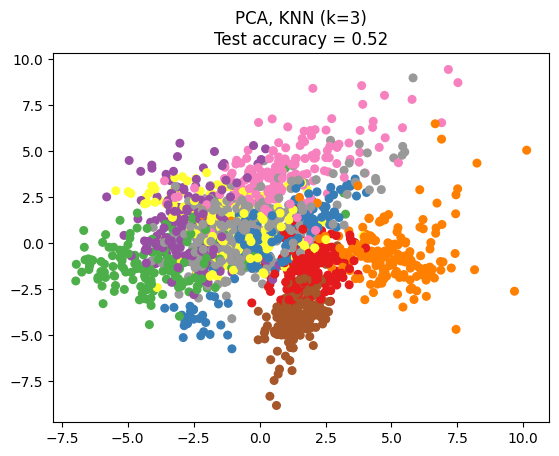

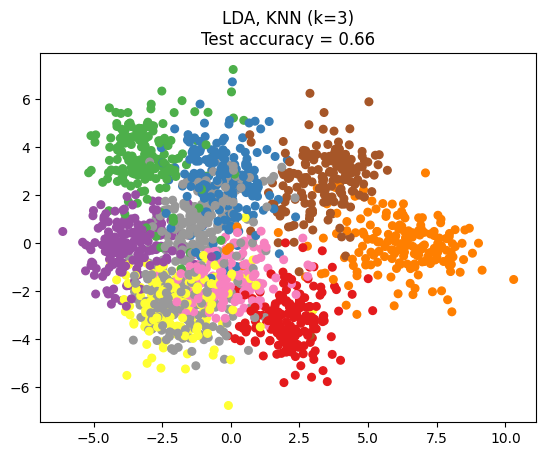

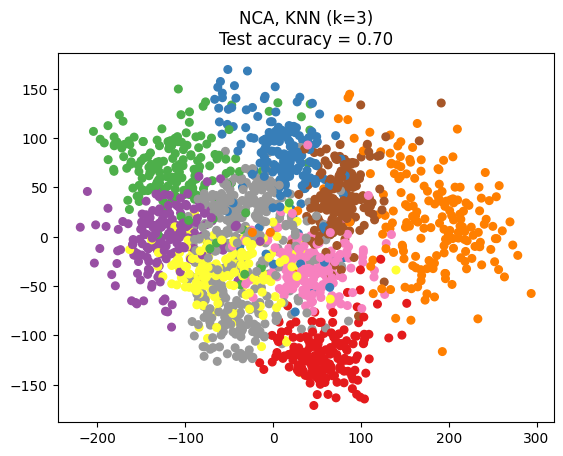

In [3]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 3
random_state = 0

# Load Digits dataset
X, y = datasets.load_digits(return_X_y=True)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn)
    )
plt.show()

# Manifold learning on handwritten digits: Locally Linear Embedding, Isomap…
    # Load digits dataset
We will load the digits dataset and only use six first of the ten available classes.

In [4]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

We can plot the first hundred digits from this data set.

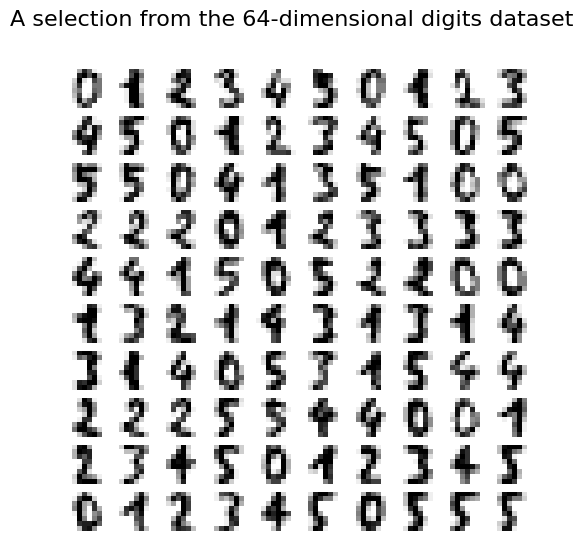

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

# Helper function to plot embedding
Below, we will use different techniques to embed the digits dataset. We will plot the projection of the original data onto each embedding. It will allow us to check whether or digits are grouped together in the embedding space, or scattered across it.

In [6]:
import numpy as np
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

# Embedding techniques comparison
Below, we compare different techniques. However, there are a couple of things to note:

the RandomTreesEmbedding is not technically a manifold embedding method, as it learn a high-dimensional representation on which we apply a dimensionality reduction method. However, it is often useful to cast a dataset into a representation in which the classes are linearly-separable.

the LinearDiscriminantAnalysis and the NeighborhoodComponentsAnalysis, are supervised dimensionality reduction method, i.e. they make use of the provided labels, contrary to other methods.

the TSNE is initialized with the embedding that is generated by PCA in this example. It ensures global stability of the embedding, i.e., the embedding does not depend on random initialization.

In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embedding": TSNE(
    n_components=2,
    n_iter=500,  # ✅ Correct parameter
    n_iter_without_progress=150,
    random_state=0,
    ),

    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

In [9]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embedding...
Computing NCA embedding...


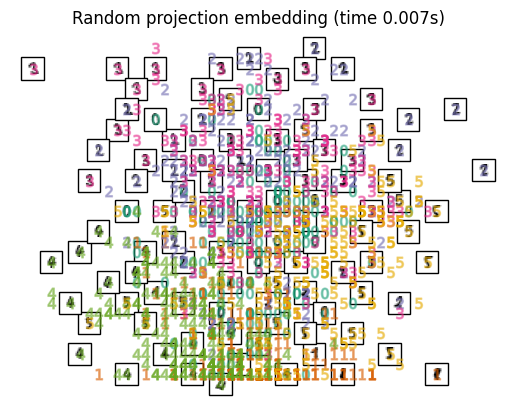

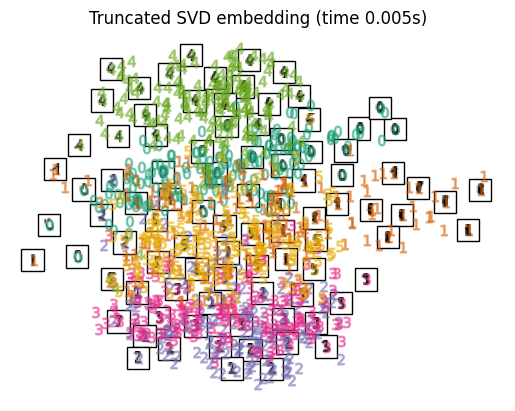

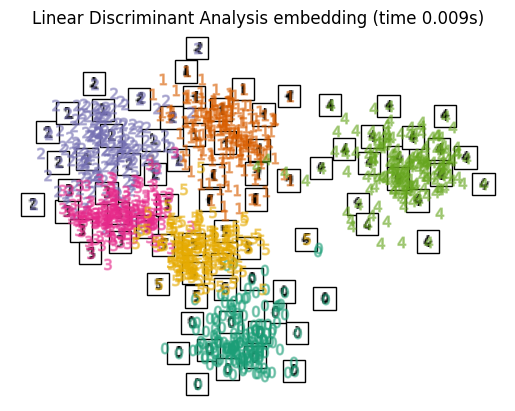

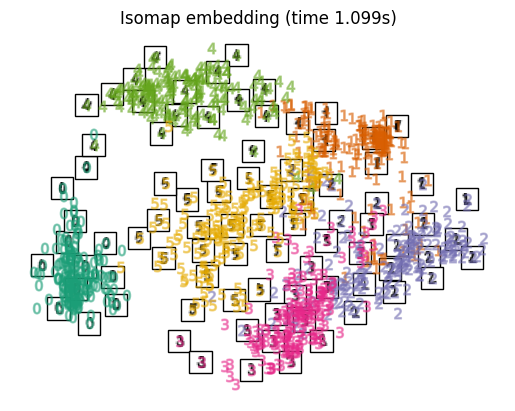

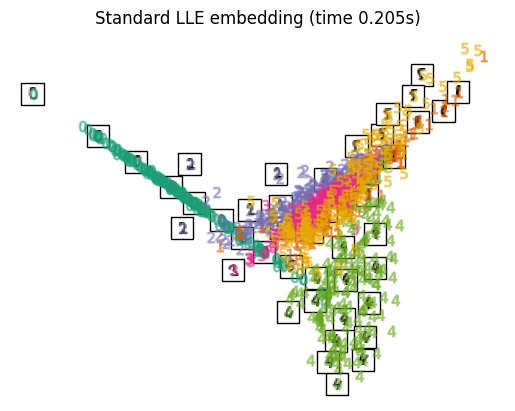

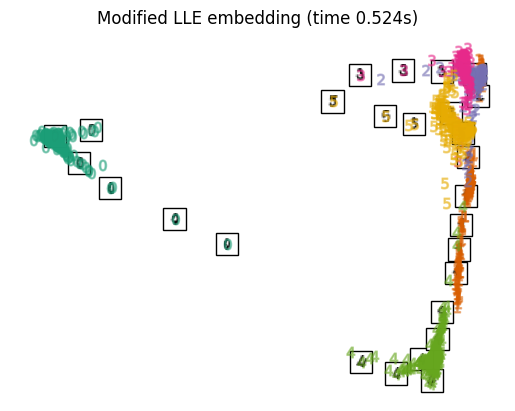

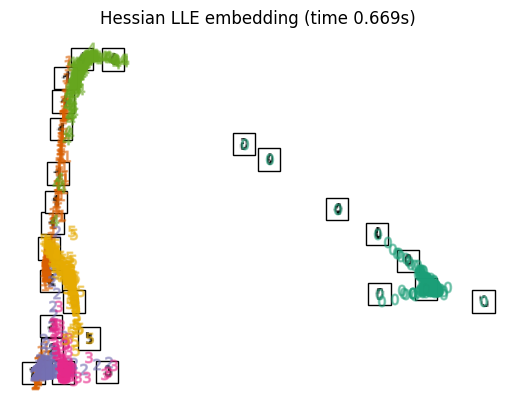

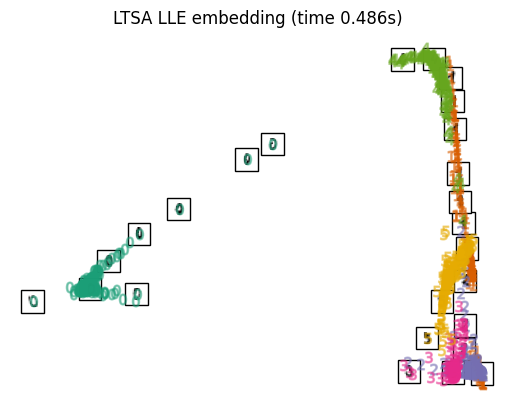

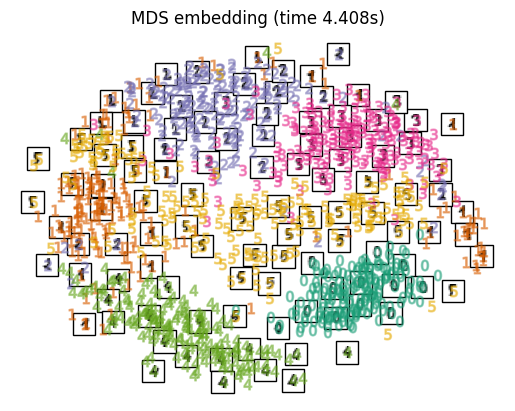

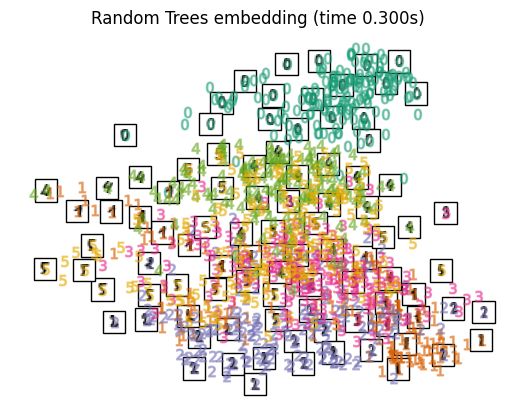

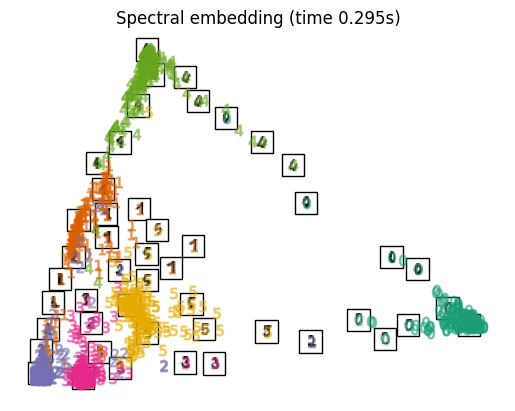

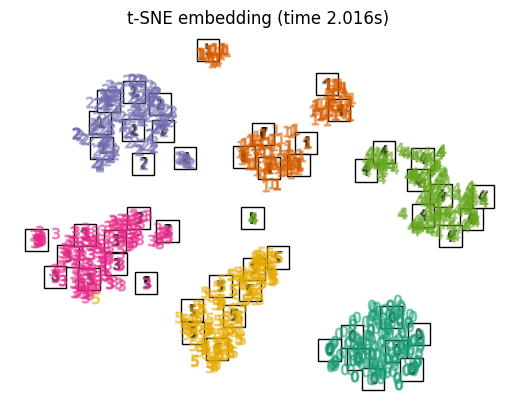

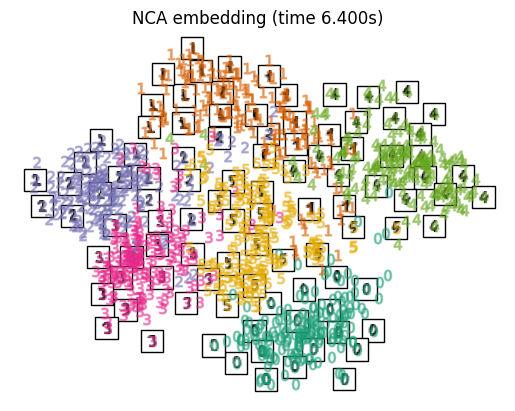

In [10]:
for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()